In [3]:
import pandas as pd
import numpy as np

# Load your dataset
df = pd.read_csv("Data-prep/valid_descriptor_dataset.csv")  # Adjust filename if needed

# Define column name for Curie temperature
temperature_col = "Temperature_K"

# Threshold and fraction to drop
low_temp_threshold = 290
fraction_to_drop = 0.04  # Drop 50% of the low-temperature samples (adjustable)

# Step 1: Identify low-Tc entries
low_temp_df = df[df[temperature_col] < low_temp_threshold]
high_temp_df = df[df[temperature_col] >= low_temp_threshold]

# Step 2: Randomly drop a fraction from low-Tc entries
np.random.seed(42)  # For reproducibility
num_to_drop = int(len(low_temp_df) * fraction_to_drop)
low_temp_sampled = low_temp_df.sample(n=(len(low_temp_df) - num_to_drop), random_state=42)

# Step 3: Combine with high-Tc entries
df_balanced = pd.concat([low_temp_sampled, high_temp_df]).reset_index(drop=True)

# Step 4: Save the balanced dataset
df_balanced.to_csv("balanced_curie_temperatures.csv", index=False)

# Report
print(f"Original dataset size: {len(df)}")
print(f"Low-Tc entries before: {len(low_temp_df)}")
print(f"Low-Tc entries after:  {len(low_temp_sampled)}")
print(f"\n --> Balanced dataset size: {len(df_balanced)}")


Original dataset size: 13116
Low-Tc entries before: 6473
Low-Tc entries after:  6215
Balanced dataset size: 12858


In [43]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import winsound
from scipy.stats import zscore


# Load dataset
df = pd.read_csv("balanced_curie_temperatures.csv")

# Top features (manually selected or from importance_df)
features = list(df.columns.values[2:])

target = "Temperature_K"

# Drop rows with missing values
df_clean = df.dropna(subset=features + [target])

print(f"Dataset size after dropna: {len(df_clean)}")


# Features and target
X = df_clean[features]
y = df_clean[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = ExtraTreesRegressor(n_estimators = 100, min_samples_split=3,random_state=42) #, max_depth=16
model.fit(X_train, y_train)

# Evaluate on test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📊 ExtraTrees Regressor (Test Set Results):")
print(f"MAE:  {mae:.2f} K")
print(f"RMSE: {rmse:.2f} K")
print(f"R²:   {r2:.4f}")





Dataset size after dropna: 12804
Dataset size after IQR outlier removal: 12804

📊 ExtraTrees Regressor (Test Set Results):
MAE:  52.19 K
RMSE: 100.91 K
R²:   0.8411


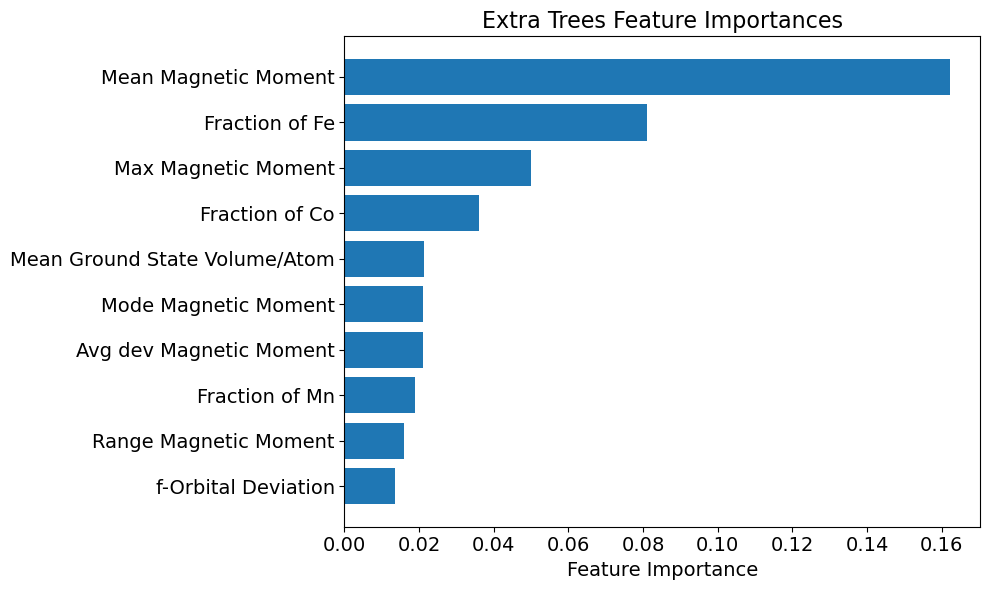

In [19]:
import matplotlib.pyplot as plt


import json
with open("column_name_dictionary.json", "r") as f:
    name_map = json.load(f)

    
# Get importances
importances = model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Apply readable names
importance_df["Readable Feature"] = importance_df["Feature"].apply(lambda f: name_map.get(f, f))


# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Readable Feature"][:10], importance_df["Importance"][:10])

# Increase font sizes
plt.xlabel("Feature Importance", fontsize=14)
plt.title("Extra Trees Feature Importances", fontsize=16)

# Increase tick label font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("feature_importance_extra_trees.png")
plt.show()


In [21]:
temp = importance_df[importance_df['Importance']>0.001]
weak_features = list(importance_df[importance_df['Importance']<0.001]['Feature'])

In [29]:
#df = pd.read_csv("Data-prep/valid_descriptor_dataset.csv")


##### # Top features 
top_features = list(temp['Feature'].values[:10])  #list(temp['Feature'].values[:]) #

target = "Temperature_K"

# Drop rows with missing values
df_clean = df.dropna(subset=top_features + [target])

# Features and target
X = df_clean[top_features]
y = df_clean[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = ExtraTreesRegressor( random_state=42) # , max_depth=21, min_samples_split=2
model.fit(X_train, y_train)

# Evaluate on test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)




100%|===================| 12795/12805 [14:03<00:00]        

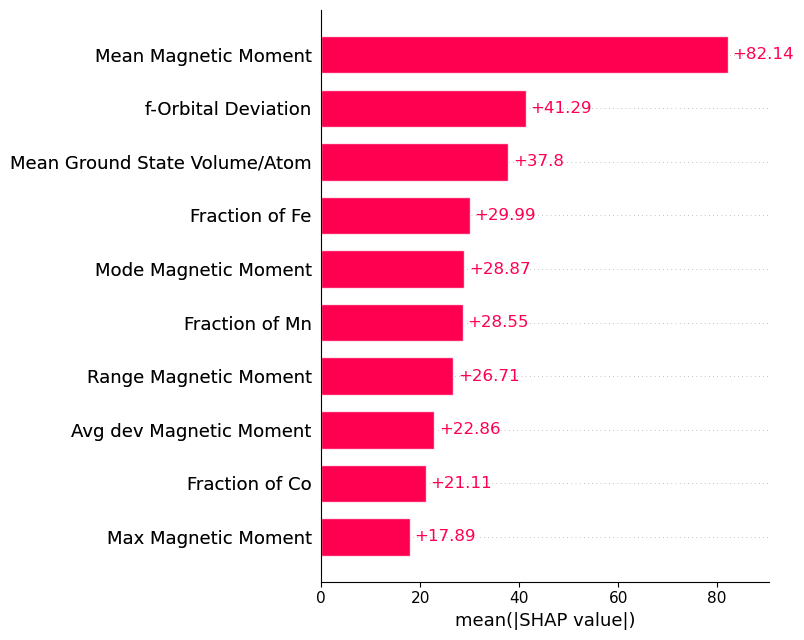

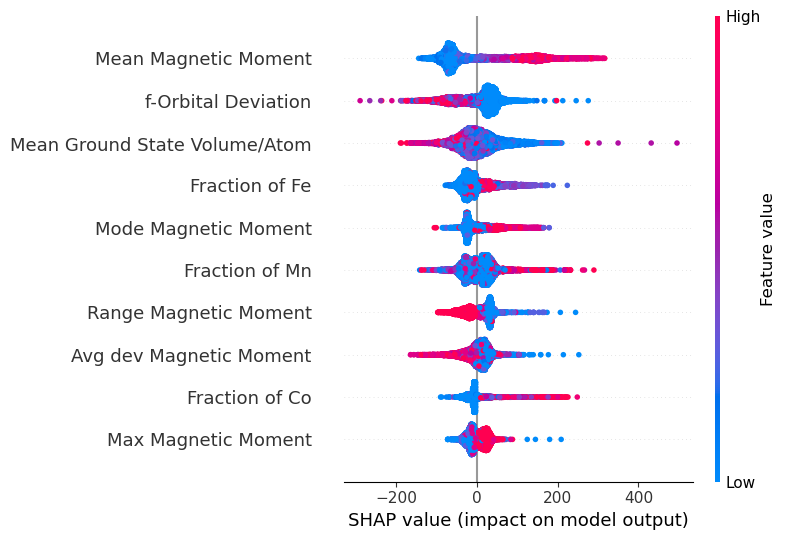

In [33]:
import shap
import matplotlib.pyplot as plt
import json

# === Load readable feature names ===
with open("column_name_dictionary.json", "r") as f:
    name_map = json.load(f)

# Replace column names in X using the dictionary
X_readable = X.rename(columns=lambda col: name_map.get(col, col))

# === Use SHAP TreeExplainer ===
explainer = shap.Explainer(model, X_readable)
shap_values = explainer(X_readable, check_additivity=False)

# === SHAP summary bar plot ===
shap.plots.bar(shap_values, show=False)
plt.tight_layout()
plt.savefig("shap_summary_bar_extratrees.png")
plt.show()

# === SHAP beeswarm plot ===
shap.plots.beeswarm(shap_values, show=False)
plt.tight_layout()
plt.savefig("shap_beeswarm_extratrees.png")
plt.show()


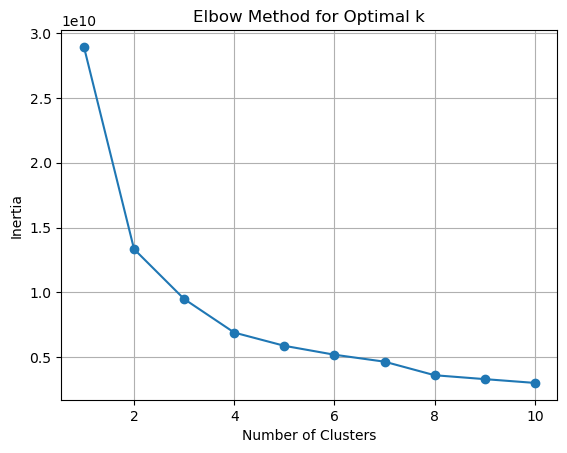

In [102]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df_clean=df_clean_clusters[:]


# Features and target
X = df_clean[top_features]
y = df_clean[target]

inertias = []
K_range = range(1, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.savefig("elbow_plot.png")

plt.show()


In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("Data-prep/valid_descriptor_dataset.csv")

##### # Top features 
top_features = list(temp['Feature'].values[:])  #list(temp['Feature'].values[:]) #

target = "Temperature_K"

# Drop rows with missing values
df_clean = df.dropna(subset=top_features + [target])

# Features and target
X = df_clean[top_features]
y = df_clean[target]

# === Step 4: KMeans clustering ===
n_clusters = 4 # You can tune this
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_clean["Cluster"] = kmeans.fit_predict(X)

# === Step 5: Train ExtraTrees per cluster ===
results = []

for cluster_id in range(n_clusters):
    cluster_df = df_clean[df_clean["Cluster"] == cluster_id]
    X = cluster_df[features]
    y = cluster_df[target_col]

    if len(cluster_df) < 20:
        print(f"⚠️ Cluster {cluster_id} has too few samples ({len(cluster_df)}) — skipping.")
        continue

    # Train-test split (80/20)
    train_frac = 0.8
    train_size = int(len(X) * train_frac)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Train model
    model = ExtraTreesRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n📊 Cluster {cluster_id} | Size: {len(cluster_df)}")
    print(f"MAE:  {mae:.2f} K")
    print(f"RMSE: {rmse:.2f} K")
    print(f"R²:   {r2:.4f}")

    results.append({
        "Cluster": cluster_id,
        "Size": len(cluster_df),
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

# === Step 6: Summary DataFrame ===
summary = pd.DataFrame(results)
summary.to_csv("extratrees_per_cluster_results.csv", index=False)
print("\n✅ Results saved to 'extratrees_per_cluster_results.csv'")

df_clean_clusters=df_clean.copy()

C:\Users\Adeel\AppData\Local\Temp\ipykernel_344\2753166094.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Cluster"] = kmeans.fit_predict(X)



📊 Cluster 0 | Size: 4744
MAE:  86.83 K
RMSE: 135.39 K
R²:   0.7989

📊 Cluster 1 | Size: 4826
MAE:  100.21 K
RMSE: 158.22 K
R²:   0.5855

📊 Cluster 2 | Size: 2730
MAE:  88.68 K
RMSE: 136.17 K
R²:   0.7348

📊 Cluster 3 | Size: 760
MAE:  138.88 K
RMSE: 254.85 K
R²:   0.3844

✅ Results saved to 'extratrees_per_cluster_results.csv'


In [63]:
df_clean=df_clean_clusters[:]

target = "Temperature_K"

top_features = list(temp['Feature'].values[:]) # list(importance_df['Feature'].values[:50]) #list(df_clean.columns)[2:]

df_clean = df_clean[df_clean["Cluster"] != 1]
df_clean = df_clean[df_clean["Cluster"] != 3]

# Features and target
X = df_clean[top_features]
y = df_clean[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = ExtraTreesRegressor(n_estimators = 150, min_samples_split=3, random_state=42) # , max_depth=21, min_samples_split=2
model.fit(X_train, y_train)

# Evaluate on test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📊 ExtraTrees Regressor (Test Set Results):")
print(f"MAE:  {mae:.2f} K")
print(f"RMSE: {rmse:.2f} K")
print(f"R²:   {r2:.4f}")



# Beep when done
winsound.Beep(1000, 500)



📊 ExtraTrees Regressor (Test Set Results):
MAE:  50.97 K
RMSE: 96.77 K
R²:   0.8713


In [64]:
# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)


mae_scores = -cross_val_score(model, X, y, scoring=mae_scorer, cv=cv)
rmse_scores = -cross_val_score(model, X, y, scoring=rmse_scorer, cv=cv)
r2_scores = cross_val_score(model, X, y, scoring='r2', cv=cv)


# Cross-validation predictions
y_cv_pred = cross_val_predict(model, X, y, cv=cv)
cv_mae = mean_absolute_error(y, y_cv_pred)
cv_rmse = np.sqrt(mean_squared_error(y, y_cv_pred))
cv_r2 = r2_score(y, y_cv_pred)

print("\n🔁 Cross-Validation (5-Fold) Results:")
print(f"MAE:  {cv_mae:.2f} K (Mean ± Std: {mae_scores.mean():.2f} ± {mae_scores.std():.2f})")
print(f"RMSE: {cv_rmse:.2f} K (Mean ± Std: {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f})")
print(f"R²:   {cv_r2:.4f} (Mean ± Std: {r2_scores.mean():.4f} ± {r2_scores.std():.4f})")

# Beep when done
winsound.Beep(1000, 500)


🔁 Cross-Validation (5-Fold) Results:
MAE:  53.77 K (Mean ± Std: 53.77 ± 2.45)
RMSE: 104.81 K (Mean ± Std: 104.74 ± 3.99)
R²:   0.8486 (Mean ± Std: 0.8485 ± 0.0119)


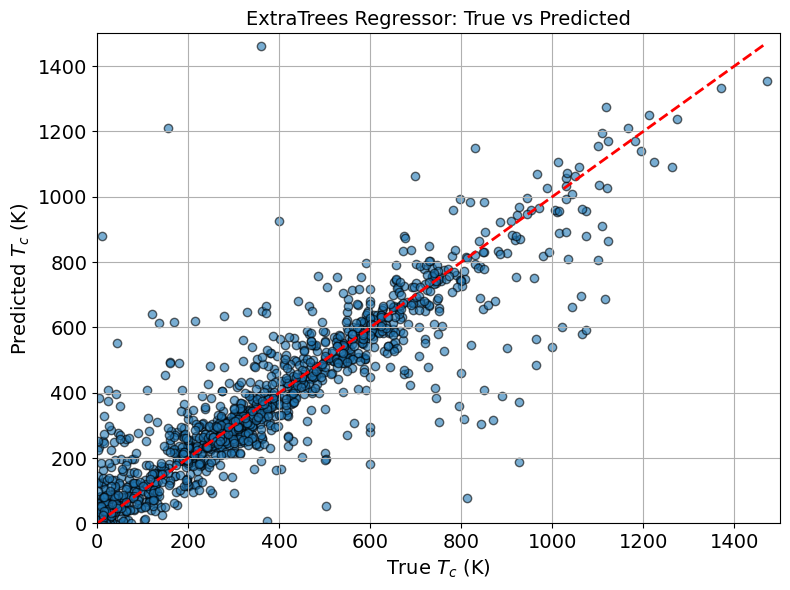

In [104]:
import matplotlib.pyplot as plt

# True vs Predicted scatter
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel(r"True $T_c$ (K)", fontsize=14)
plt.ylabel(r"Predicted $T_c$ (K)", fontsize=14)
plt.title("ExtraTrees Regressor: True vs Predicted", fontsize=14)
plt.grid(True)
plt.xlim(0,1500)
plt.ylim(0,1500)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("true_vs_predicted_extra_tree_regressor.png")
plt.tight_layout()
plt.show()


In [71]:
# === Step 4: Load blind dataset ===
blind_df = pd.read_csv("Data-prep/data-prep-test/valid_descriptor_dataset_test.csv")  # ⬅️ update filename

# === Step 5: Clean and prepare blind test features ===
blind_df = blind_df.dropna(subset=top_features)  # Drop if missing important features
X_blind = blind_df[top_features]


# === Step 6: Predict ===
y_pred_blind = model.predict(X_blind)
blind_df["Predicted_Curie_Temperature_K"] = y_pred_blind

y_blind_true = blind_df["Temperature_K"]

# === Step 6: Evaluate performance ===
mae = mean_absolute_error(y_blind_true, y_pred_blind)
rmse = np.sqrt(mean_squared_error(y_blind_true, y_pred_blind))
r2 = r2_score(y_blind_true, y_pred_blind)

print("📊 Blind Test Evaluation:")
print(f"MAE:  {mae:.2f} K")
print(f"RMSE: {rmse:.2f} K")
print(f"R²:   {r2:.4f}")



📊 Blind Test Evaluation:
MAE:  90.49 K
RMSE: 150.44 K
R²:   0.7098


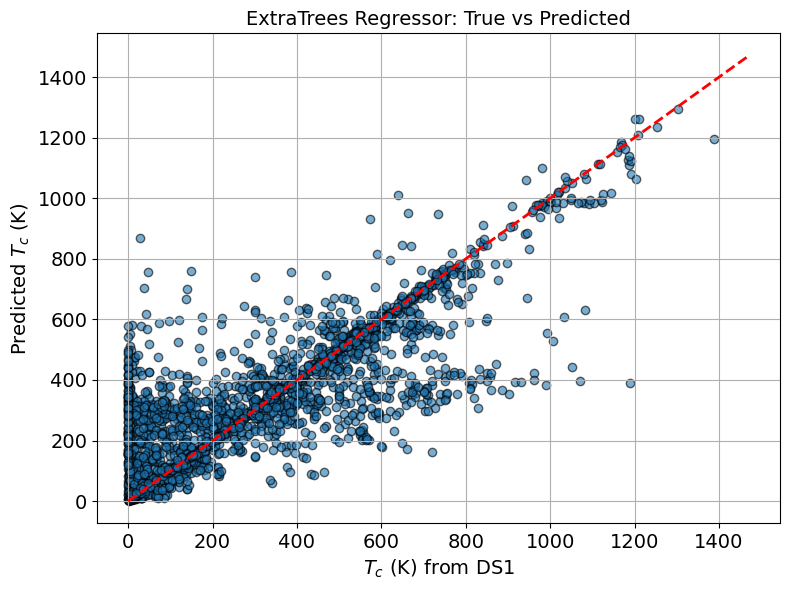

In [73]:
import matplotlib.pyplot as plt

# True vs Predicted scatter
plt.figure(figsize=(8, 6))
plt.scatter(y_blind_true, y_pred_blind, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel(r"$T_c$ (K) from DS1", fontsize = 14)
plt.ylabel(r"Predicted $T_c$ (K)", fontsize = 14)
plt.title("ExtraTrees Regressor: True vs Predicted", fontsize = 14)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.xlim(0,1500)
# plt.ylim(0,1500)
plt.savefig("DS1-true_vs_predicted_extra_tree_regressor.png")
plt.tight_layout()
plt.show()

In [75]:
within_50 = (abs(y_pred_blind - y_blind_true) <= 50).mean() * 100
within_100 = (abs(y_pred_blind - y_blind_true) <= 100).mean() * 100
print(f"✅ {within_50:.1f}% within ±50 K")
print(f"✅ {within_100:.1f}% within ±100 K")


✅ 55.0% within ±50 K
✅ 69.1% within ±100 K


In [81]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Define models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=4),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

results = []

# Initialize scalers
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for name, model in models.items():
    if name in ["KNN", "Neural Network"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })

# Display results
results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df


,Model,MAE,RMSE,R²
0,Extra Trees,50.762010,97.532286,0.869218
1,Random Forest,57.479584,102.927006,0.854350
2,XGBoost,63.066022,105.961960,0.845634
3,Neural Network,68.984963,123.008214,0.791973
4,KNN,73.503219,128.605141,0.772612


In [82]:
from collections import Counter
from pymatgen.core import Composition

df_clean=df_clean_clusters[:]

def get_top_elements(df_subset, n=10):
    elements = []
    for formula in df_subset["Material"]:
        try:
            comp = Composition(formula)
            elements += list(comp.elements)
        except:
            continue
    return Counter(elements).most_common(n)

print("Cluster 0:")
print(get_top_elements(df_clean[df_clean["Cluster"] == 0]))

print("\nCluster 1:")
print(get_top_elements(df_clean[df_clean["Cluster"] == 1]))

print("\nCluster 2:")
print(get_top_elements(df_clean[df_clean["Cluster"] == 2]))

print("\nCluster 3:")
print(get_top_elements(df_clean[df_clean["Cluster"] == 3]))


Cluster 0:
[(Element Fe, 2539), (Element Co, 1679), (Element Si, 1155), (Element B, 941), (Element Ni, 874), (Element Mn, 849), (Element Gd, 731), (Element Ge, 592), (Element Nd, 485), (Element Al, 458)]

Cluster 1:
[(Element O, 3930), (Element Mn, 2536), (Element La, 1621), (Element Fe, 1525), (Element Sr, 1178), (Element Co, 868), (Element Ca, 818), (Element Zn, 576), (Element Ni, 550), (Element Cr, 482)]

Cluster 2:
[(Element Mn, 1174), (Element Fe, 906), (Element Ni, 704), (Element Ga, 678), (Element Co, 616), (Element Al, 559), (Element Sn, 387), (Element Ge, 258), (Element In, 257), (Element Si, 247)]

Cluster 3:
[(Element C, 520), (Element Fe, 425), (Element B, 166), (Element Co, 162), (Element Si, 149), (Element Mn, 148), (Element O, 118), (Element P, 101), (Element Cr, 74), (Element Al, 71)]


In [97]:
from sklearn.manifold import TSNE
import seaborn as sns

df_clean=df_clean_clusters[:]
feature_cols = list(importance_df['Feature'].values[:50])


# === Step 3: Normalize the features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[feature_cols])

# === Step 4: Run t-SNE ===
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# Add t-SNE coordinates back to DataFrame
df_clean["tSNE-1"] = X_embedded[:, 0]
df_clean["tSNE-2"] = X_embedded[:, 1]




C:\Users\Adeel\AppData\Local\Temp\ipykernel_344\107047039.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["tSNE-1"] = X_embedded[:, 0]
C:\Users\Adeel\AppData\Local\Temp\ipykernel_344\107047039.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["tSNE-2"] = X_embedded[:, 1]


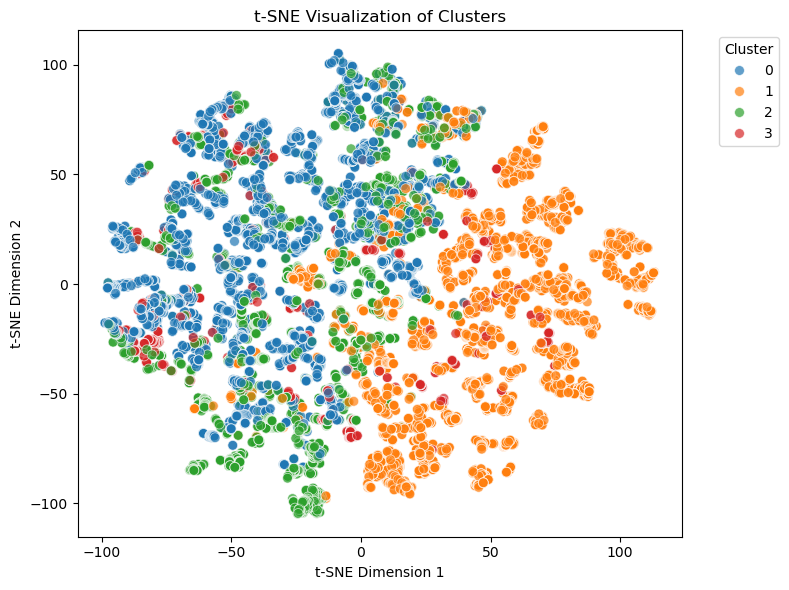

In [91]:
import seaborn as sns
# === Step 5: Plot ===
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clean, x="tSNE-1", y="tSNE-2", hue="Cluster", palette="tab10", s=50, alpha=0.7)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("tsne_clusters.png", dpi=300)
plt.show()

In [93]:
from collections import Counter
from pymatgen.core import Composition

df_clean = df_clean_clusters[:]  # Copy of the dataframe

def get_top_5_elements_dict(df_subset):
    elements = []
    for formula in df_subset["Material"]:
        try:
            comp = Composition(formula)
            elements += [el.symbol for el in comp.elements]  # Use symbols only
        except:
            continue
    # Return dict of top 5 elements
    return dict(Counter(elements).most_common(5))

# Final dictionary
cluster_elements = {}

# Loop through all clusters
for cluster_num in sorted(df_clean["Cluster"].unique()):
    cluster_label = f"Cluster {cluster_num}"
    top_5_dict = get_top_5_elements_dict(df_clean[df_clean["Cluster"] == cluster_num])
    cluster_elements[cluster_label] = top_5_dict

# Print the final result
print(cluster_elements)


{'Cluster 0': {'Fe': 2539, 'Co': 1679, 'Si': 1155, 'B': 941, 'Ni': 874}, 'Cluster 1': {'O': 3930, 'Mn': 2536, 'La': 1621, 'Fe': 1525, 'Sr': 1178}, 'Cluster 2': {'Mn': 1174, 'Fe': 906, 'Ni': 704, 'Ga': 678, 'Co': 616}, 'Cluster 3': {'C': 520, 'Fe': 425, 'B': 166, 'Co': 162, 'Si': 149}}


<Figure size 1000x600 with 0 Axes>

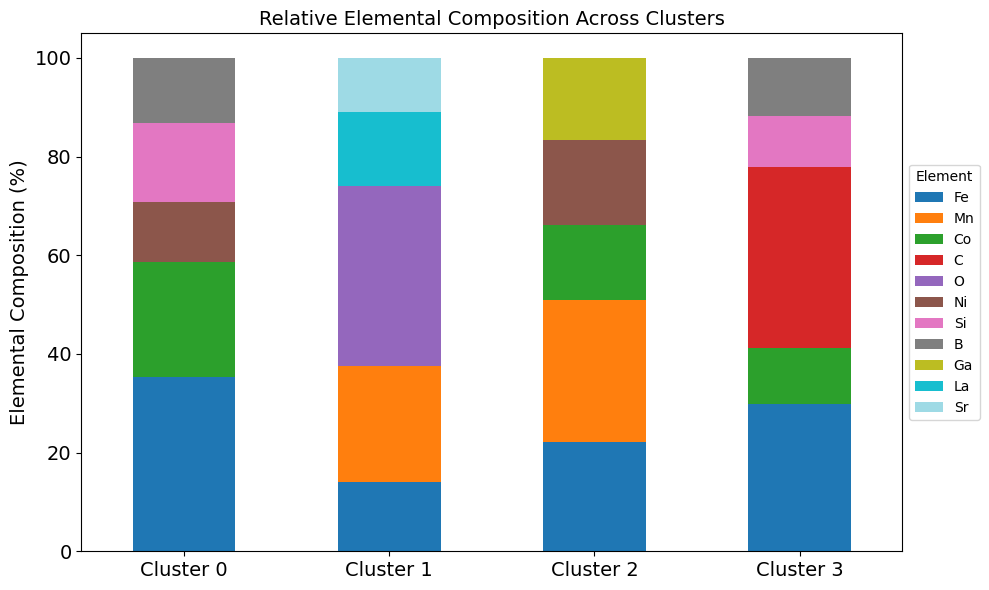

In [95]:
import pandas as pd
import matplotlib.pyplot as plt


# Convert to DataFrame and fill missing values with 0
df = pd.DataFrame(cluster_elements).fillna(0)

# Convert counts to percentage
df_pct = df.div(df.sum(axis=0), axis=1) * 100

# Sort rows by overall average for consistent coloring
df_pct = df_pct.loc[df_pct.mean(axis=1).sort_values(ascending=False).index]

# Plot
plt.figure(figsize=(10, 6))
df_pct.T.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

plt.ylabel("Elemental Composition (%)", fontsize = 14)
plt.title("Relative Elemental Composition Across Clusters", fontsize = 14)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Element')
plt.tight_layout()
plt.savefig("cluster_element_composition_percentage.png", dpi=300)
plt.show()
